In [1]:
import gym
import sys
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

In [39]:
env = gym.make('Blackjack-v0')

## 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [100]:
def draw_till_19_pol(obs):
    return 1 if obs[0] < 19 else 0
def draw_till_20_pol(obs):
    return 1 if obs[0] < 20 else 0
def draw_till_21_pol(obs):
    return 1 if obs[0] < 21 else 0

In [101]:
def calc_payoffs(env, rounds, players, pol):
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 

        while rd <= rounds:
            action = pol(env._get_obs())
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset()
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('количество игроков')
    plt.ylabel('выигрыш после ' + str(rounds) + ' раундов')
    plt.show()    
    print ("Средний выигрыш игрока после {} раундов = {}".format(rounds, sum(average_payouts)/players))

Говорим stick, если у нас на руках комбинация в 19 очков, во всех остальных случаях говорим hit:


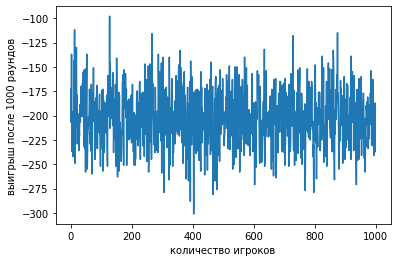

Средний выигрыш игрока после 1000 раундов = -202.529
Говорим stick, если у нас на руках комбинация в 20 очков, во всех остальных случаях говорим hit:


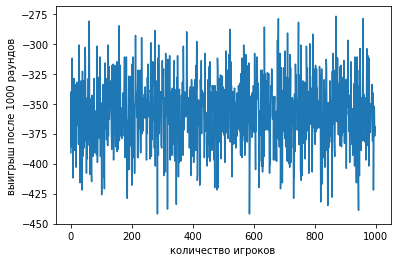

Средний выигрыш игрока после 1000 раундов = -357.53
Говорим stick, если у нас на руках комбинация в 21 очко, во всех остальных случаях говорим hit:


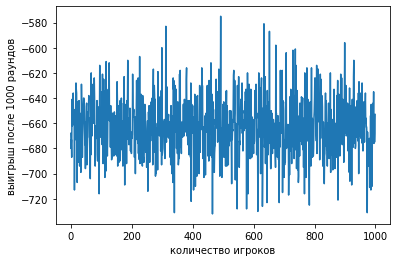

Средний выигрыш игрока после 1000 раундов = -662.656


In [102]:
env.reset()
print('Говорим stick, если у нас на руках комбинация в 19 очков, во всех остальных случаях говорим hit:')
calc_payoffs(env, 1000, 1000, draw_till_19_pol)
env.reset()
print('Говорим stick, если у нас на руках комбинация в 20 очков, во всех остальных случаях говорим hit:')
calc_payoffs(env, 1000, 1000, draw_till_20_pol)
env.reset()
print('Говорим stick, если у нас на руках комбинация в 21 очко, во всех остальных случаях говорим hit:')
calc_payoffs(env, 1000, 1000, draw_till_21_pol)

## 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [55]:
def get_probs(Q_state, epsilon, nA):
    probs = np.ones(nA) * epsilon/nA
    greedy_action = np.argmax(Q_state)
    probs[greedy_action] = 1 - epsilon + epsilon/nA
    
    return probs

def generate_episode(env, Q, epsilon, nA):  
    episode = []
    state = env.reset()
    
    while True:
        action = np.random.choice(np.arange(nA), p = get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample() 
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
        
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:] * discounts[:-(1 + i)]) - old_Q)
        
    return Q 

In [56]:
def mc_control(env, num_episodes, alpha, gamma = 1.0, eps_start = 1.0, eps_decay = 0.9999965, eps_min = 0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    for i_episode in range(num_episodes):
        epsilon = max(epsilon * eps_decay, eps_min)
        episode = generate_episode(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
        if i_episode % 1000 == 0:
            print('\rEpisode {}/{}.'.format(i_episode, num_episodes), end = "")
            sys.stdout.flush()
        
    policy = dict((state, np.argmax(action)) for state, action in Q.items())
    
    return policy, Q        

In [62]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Текущая сумма очков у игрока')
        ax.set_ylabel('Видимая позиция дилера')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

### Запускаем обучение

In [58]:
policy, Q = mc_control(env, 1000000, 0.02)
V = dict((k, np.max(v)) for k, v in Q.items())

Episode 999000/1000000.

### Получившиеся графики state-value

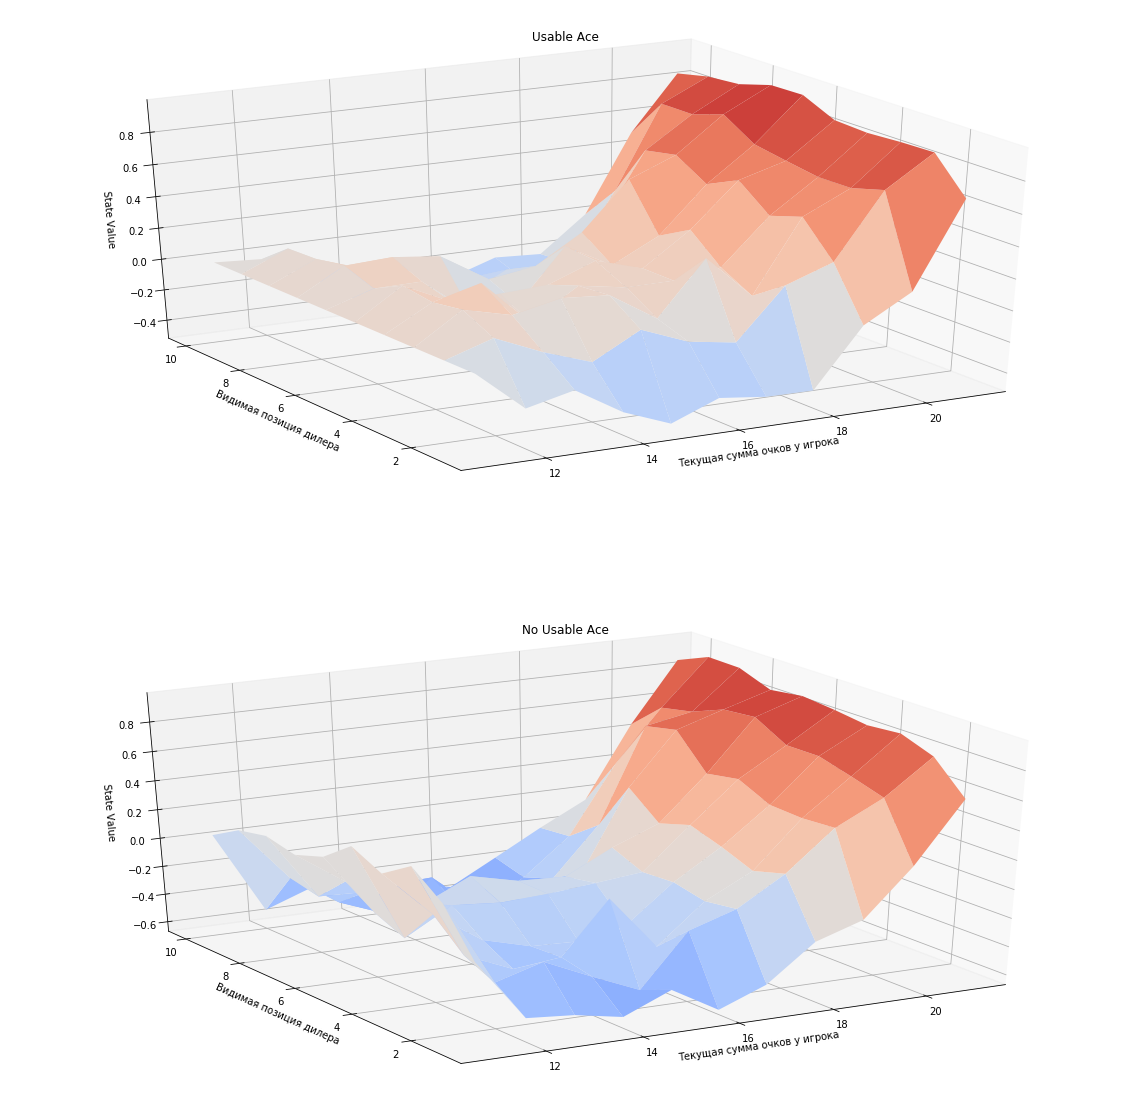

In [63]:
plot_blackjack_values(V)

In [60]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Текущая сумма очков у игрока')
        ax.set_ylabel('Видимая позиция дилера')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

### График нашей стратегии

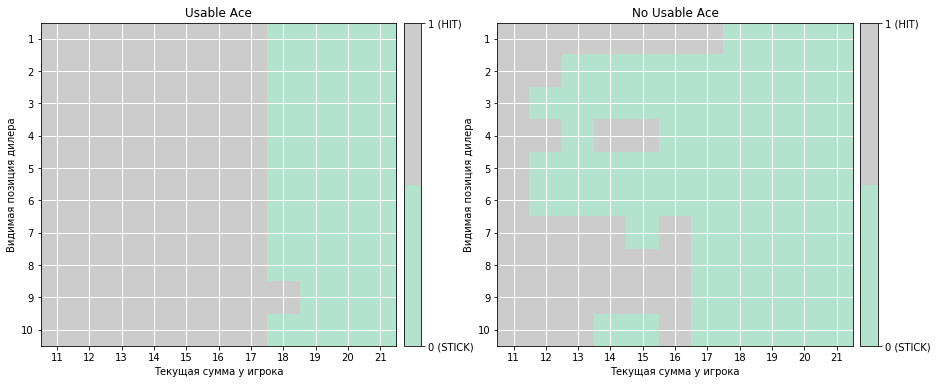

In [61]:
plot_policy(policy)

### Теперь узнаем сколько выигрывает казино у нашей стратегии.

In [86]:
def use_policy(obs):
    return policy[(obs[0], obs[1], obs[2])]

In [87]:
def calc_payoffs(env, rounds, players):
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 

        while rd <= rounds:
            action = use_policy(env._get_obs())
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset()
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('количество игроков')
    plt.ylabel('выигрыш после ' + str(rounds) + ' раундов')
    plt.show()    
    print ("Средний выигрыш игрока после {} раундов = {}".format(rounds, sum(average_payouts)/players))

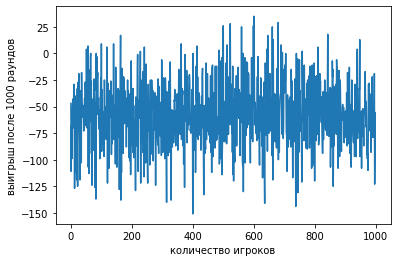

Средний выигрыш игрока после 1000 раундов = -57.653


In [88]:
env.reset()
calc_payoffs(env, 1000, 1000)

## 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки. 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Просто изменим функцию генерации эпизода, в которой пропишем на последнем ходе удвоение ставки.

In [90]:
def generate_episode(env, Q, epsilon, nA):  
    episode = []
    state = env.reset()
    
    while True:
        action = np.random.choice(np.arange(nA), p = get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample() 
        next_state, reward, done, info = env.step(action)
        if done:
            episode.append((state, action, 2.0*reward))
        else:
            episode.append((state, action, reward))
        state = next_state
        if done:
            break
        
    return episode

### Запускаем обучение

In [91]:
policy, Q = mc_control(env, 1000000, 0.02)
V = dict((k, np.max(v)) for k, v in Q.items())

Episode 999000/1000000.

### Получившиеся графики state-value

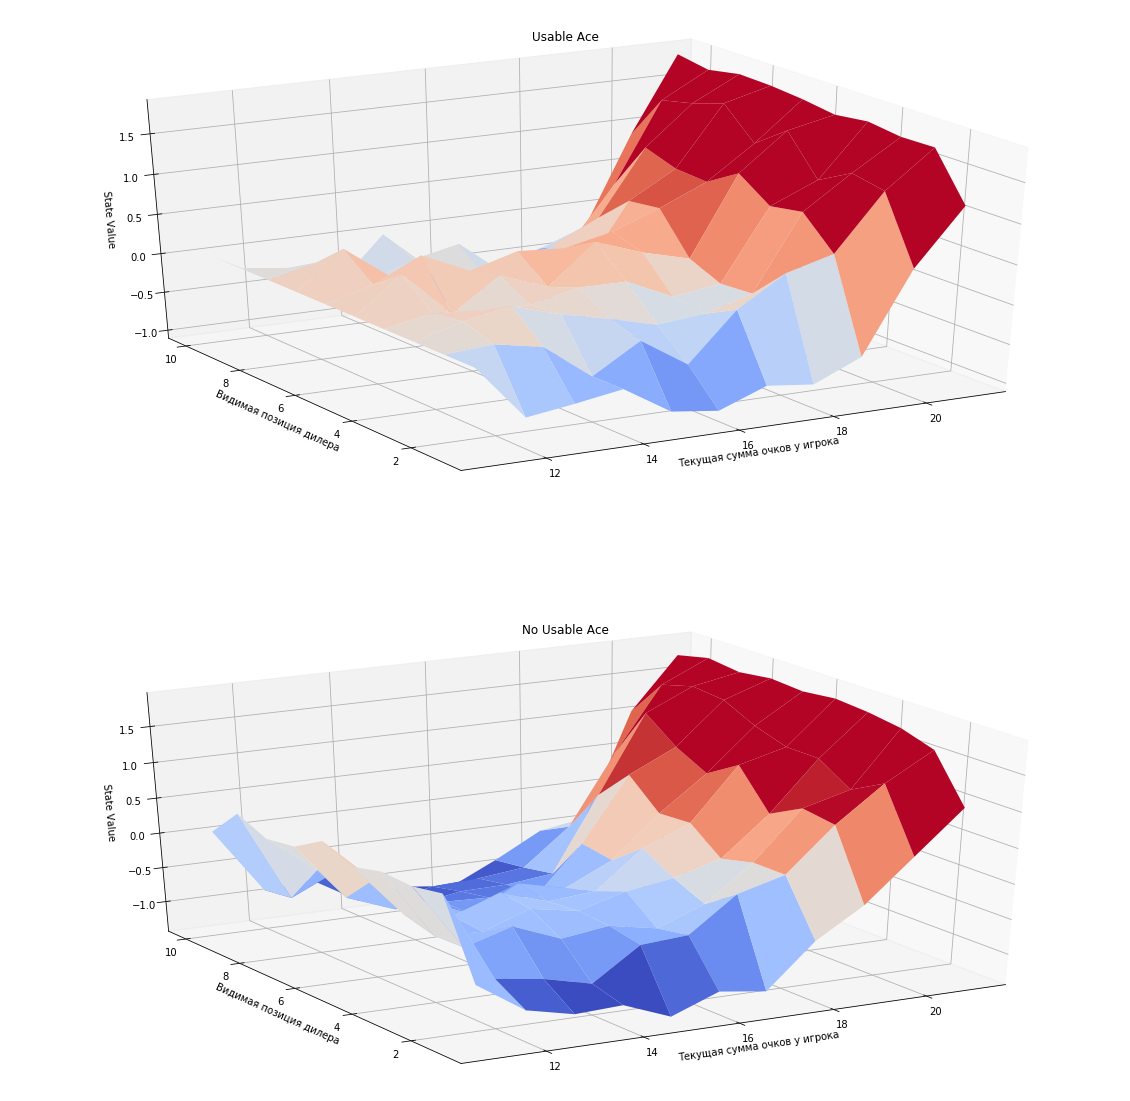

In [92]:
plot_blackjack_values(V)

### График нашей стратегии

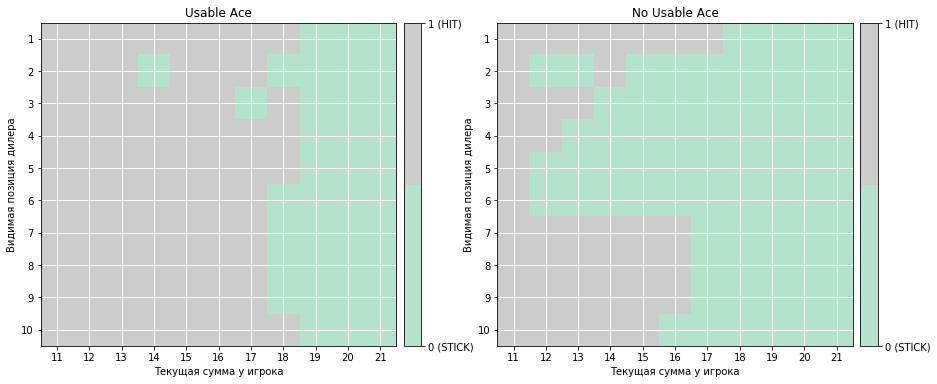

In [93]:
plot_policy(policy)

### Узнаем наш выигрыш или казино

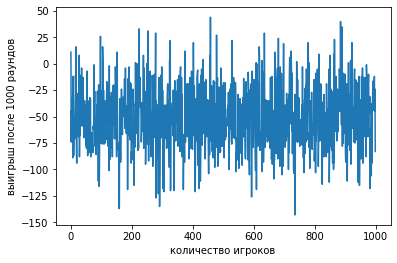

Средний выигрыш игрока после 1000 раундов = -50.827


In [94]:
env.reset()
calc_payoffs(env, 1000, 1000)

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Для этого задания потребовалось поправить "кишки" библиотеки gym. Добавил свой environment Bj-v1, в котором прописал использование карт и перемешивание колоды после того, как в ней стало меньше 15 карт.

In [95]:
env = gym.make('Bj-v1')

### Запускаем обучение

In [96]:
policy, Q = mc_control(env, 1000000, 0.02)
V = dict((k, np.max(v)) for k, v in Q.items())

Episode 999000/1000000.

### Получившиеся графики state-value

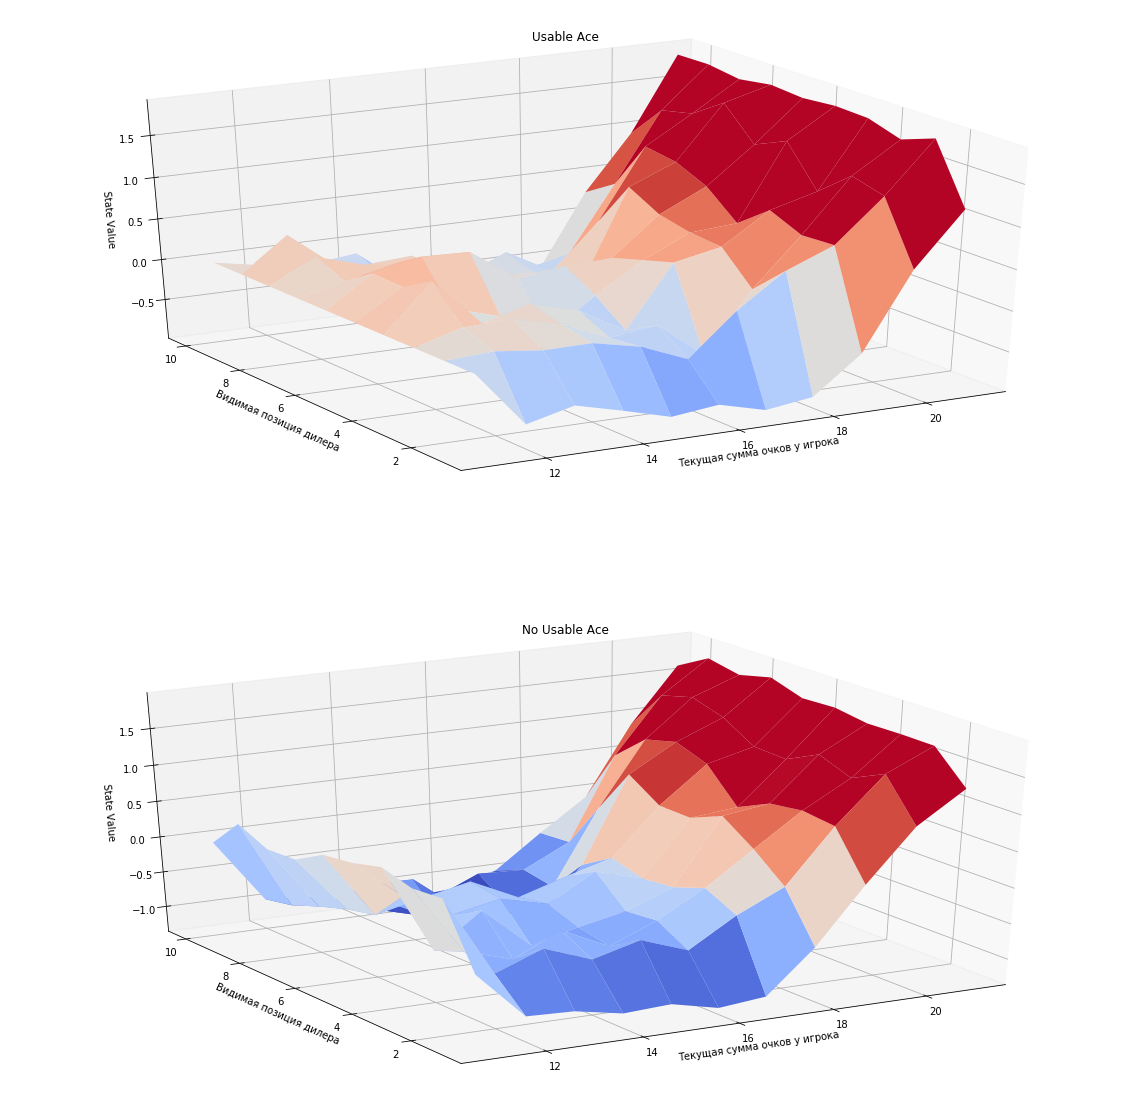

In [97]:
plot_blackjack_values(V)

### График нашей стратегии

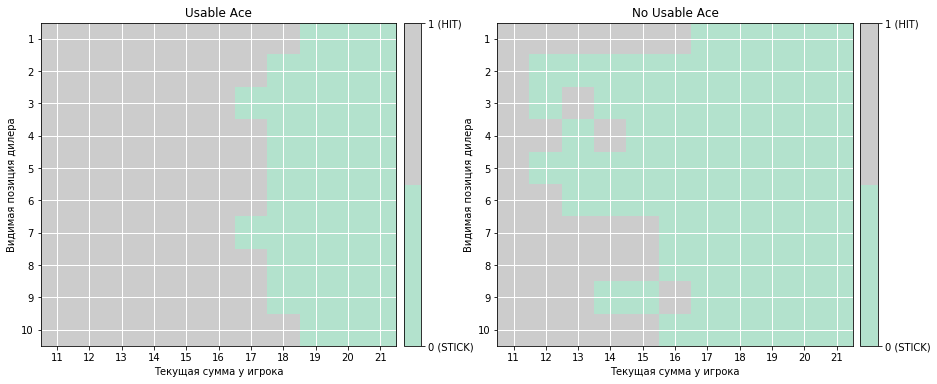

In [98]:
plot_policy(policy)

### Узнаем наш выигрыш или казино

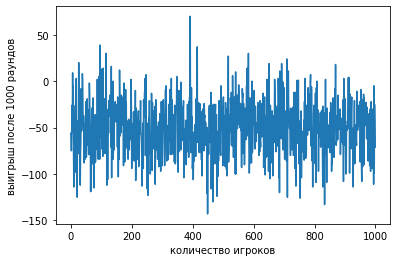

Средний выигрыш игрока после 1000 раундов = -51.118


In [99]:
env.reset()
calc_payoffs(env, 1000, 1000)